<a href="https://colab.research.google.com/github/madelezhia/vision-systems-lab/blob/main/II-SoTA/PyTorch_classification_ViT_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformers Using PyTorch

In [1]:
from google.colab import drive
drive.mount('/gdrive')

import tarfile

tar_path = '/gdrive/MyDrive/Colab Notebooks/Portfolio/II-SoTA/images_dataSAT.tar'
extract_dir = '.'
with tarfile.open(tar_path, 'r:*') as tar_ref:
    tar_ref.extractall(path=extract_dir)
print(f"Successfully extracted to '{extract_dir}'.")

Mounted at /gdrive


/tmp/ipython-input-2758669477.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall(path=extract_dir)


Successfully extracted to '.'.


## Package installation

In [2]:
%%time
%%capture captured_output
%pip install numpy==1.24.4
%pip install matplotlib==3.9.2

CPU times: user 3.58 s, sys: 517 ms, total: 4.1 s
Wall time: 30.9 s


### Install PyTorch library


In [3]:
%%time
%pip install torch==2.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 6.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparselt-cu12
    Found existing installation: nvidia-cusparselt-cu12 0.7.1
    Uninstalling nvidia-cusparselt-cu12-0.7.1:
      Successfully uninstalled nvidia-cusparselt-cu12-0.7.1
  Attempting uninstall: triton
    Found existing installation: triton 3.4.0
    Uninstalling triton-3.4.0:
      Successfully uninstalled triton-3.4.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.27.3
    Uninstalling nvidia-nccl-cu12-2.27.3:
      Successfully uninstalled nvidia-nccl-cu12-2.27.3
  Attempting uninstall: nvidia-cudnn-

### Install PyTorch helper libraries


In [4]:
%%time
%pip install torchvision==0.22

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.4 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.23.0+cu126
    Uninstalling torchvision-0.23.0+cu126:
      Successfully uninstalled torchvision-0.23.0+cu126
CPU times: user 3.03 s, sys: 376 ms, total: 3.41 s
Wall time: 16.5 s


## Library imports and setup


In [5]:
%%time
import warnings
warnings.filterwarnings('ignore')

import os
import time
import httpx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

def present_time():
        return datetime.now().strftime('%Y%m%d_%H%M%S')


CPU times: user 143 ms, sys: 14.5 ms, total: 157 ms
Wall time: 306 ms


### PyTorch library imports


In [6]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
print("Imported PyTorch libraries")

Imported PyTorch libraries
CPU times: user 9.09 s, sys: 798 ms, total: 9.88 s
Wall time: 19.1 s


In [7]:
data_dir = "/gdrive/MyDrive/Colab Notebooks/Portfolio/II-SoTA/"
pytorch_state_dict_name = "ai_capstone_pytorch_best_model_20250713.pth"
pytorch_state_dict_path = os.path.join(data_dir, pytorch_state_dict_name)

## Ensuring repeatability in PyTorch


In [8]:
def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch (CPU & all GPUs) and
    make cuDNN run in deterministic mode."""
    # ---- Python and NumPy -------------------------------------------
    random.seed(seed)
    np.random.seed(seed)

    # ---- PyTorch (CPU  &  GPU) --------------------------------------
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # ---- cuDNN: force repeatable convolutions -----------------------
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False


In [9]:
SEED = 7331
set_seed(SEED)
print(f"Global seed set to {SEED} - main process is now deterministic.")

Global seed set to 7331 - main process is now deterministic.


## Defining pre-trained CNN backbone


In [10]:
class ConvNet(nn.Module):
    '''
    Class to define the architecture same as the imported pre-trained CNN model for extracting the` feature map
    '''
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024)
        )

    def forward_features(self, x):
        return self.features(x)      # (B,1024,H,W)


# Vision Transformers


## Patch embedding


In [11]:
class PatchEmbed(nn.Module):
    def __init__(self, input_channel=1024, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1)  # 1×1 conv
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B,L,D)
        return x

## Multi-head self-attention (MHSA) module


In [12]:
class MHSA(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2)  # (B, heads, N, d)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

## Transformer block


In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = nn.Sequential(
                                    nn.Linear(dim, int(dim * mlp_ratio)),
                                    nn.GELU(), nn.Dropout(dropout),
                                    nn.Linear(int(dim * mlp_ratio), dim),
                                    nn.Dropout(dropout))
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

## Vision Transformer (ViT) model


In [14]:
class ViT(nn.Module):
    def __init__(self, in_ch=1024, num_classes=2,
                 embed_dim=768, depth=6, heads=8,
                 mlp_ratio=4., dropout=0.1, max_tokens=50):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim)           # 1×1 conv
        self.cls   = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos   = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                          # x: (B,C,H,W)
        x = self.patch(x)                          # (B,L,D)
        B, L, _ = x.shape
        cls = self.cls.expand(B, -1, -1)           # (B,1,D)
        x = torch.cat((cls, x), 1)                 # (B,L+1,D)
        x = x + self.pos[:, :L + 1]                # match seq-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])       # CLS token

## CNN-ViT hybrid model


In [15]:
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2, embed_dim=768, depth=6, heads=8):
        super().__init__()
        self.cnn = ConvNet(num_classes)            # load weights later
        self.vit = ViT(num_classes=num_classes,
                       embed_dim=embed_dim,
                       depth=depth,
                       heads=heads)
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

# Model training

In [16]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training  ")):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

# Model evaluation

In [17]:
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

## Data preparation and loading

In [18]:
dataset_path = os.path.join(extract_dir, "images_dataSAT") #os.path.join(data_dir, "images_dataSAT")
img_size = 64
batch_size = 32
lr = 0.001
num_cls  = 2


### Training data transformations

In [19]:
train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.RandomRotation(40),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

### Validation data transformations


In [20]:
val_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
test_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

### The DataLoader

In [21]:
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)

train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = test_transform

In [22]:
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                         )

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                       )
test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                       )

## Model initialization and training loop

In [23]:
device   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")


epochs     = 5
attn_heads = 6
depth      = 3
embed_dim  = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_state_dict.pth"

model     = CNN_ViT_Hybrid(num_classes=num_cls,
                            heads=attn_heads,
                            depth=depth,
                            embed_dim=embed_dim
                           ).to(device)


# ------------------------------------------------------------------ #
# loading pre-trained CNN weights
model.cnn.load_state_dict(torch.load(pytorch_state_dict_path), strict=False)
# ------------------------------------------------------------------ #


criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=lr)


best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
tr_acc_all = []
te_acc_all = []

training_time = []
for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch:02d}/{epochs:02d} started at {present_time()} (UTC)")
    tr_loss,tr_acc = train(model, train_loader, optimizer, criterion, device)
    te_loss,te_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    tr_acc_all.append(tr_acc)
    te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)

    # Save the best model
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


Training the model on cpu
epochs:5 | batch:32 | attn_heads:6 | depth:3 | embed_dim:768

Epoch 01/05 started at 20251103_165945 (UTC)


Validation: 100%|██████████| 38/38 [00:22<00:00,  1.70it/s]


Epoch 01 | train loss 0.2860 acc 0.9414 | val loss 0.0444 acc 0.9783 | in  298.60s
Current loss (0.0444) lower than previous best loss (inf), Saving current model state

Epoch 02/05 started at 20251103_170444 (UTC)


Validation: 100%|██████████| 38/38 [00:21<00:00,  1.75it/s]


Epoch 02 | train loss 0.1009 acc 0.9697 | val loss 0.0483 acc 0.9875 | in  294.97s

Epoch 03/05 started at 20251103_170939 (UTC)


Validation: 100%|██████████| 38/38 [00:20<00:00,  1.85it/s]


Epoch 03 | train loss 0.0741 acc 0.9783 | val loss 0.0098 acc 0.9967 | in  288.04s
Current loss (0.0098) lower than previous best loss (0.0444), Saving current model state

Epoch 04/05 started at 20251103_171427 (UTC)


Validation: 100%|██████████| 38/38 [00:20<00:00,  1.85it/s]


Epoch 04 | train loss 0.0631 acc 0.9781 | val loss 0.0381 acc 0.9908 | in  284.04s

Epoch 05/05 started at 20251103_171911 (UTC)


Validation: 100%|██████████| 38/38 [00:21<00:00,  1.74it/s]

Epoch 05 | train loss 0.0523 acc 0.9825 | val loss 0.0107 acc 0.9975 | in  287.64s
epochs:5 | batch:32 | attn_heads:6 | depth:3 | embed_dim:768


## Plotting training and validation accuracy and loss

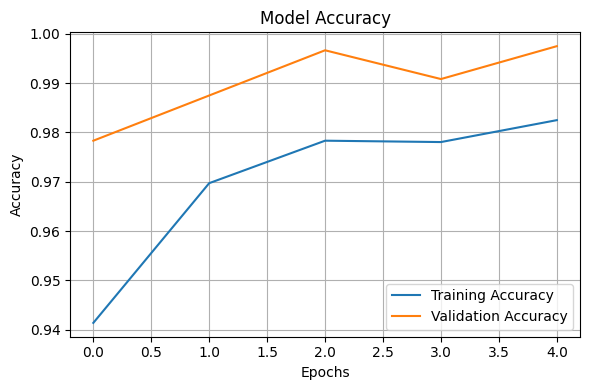

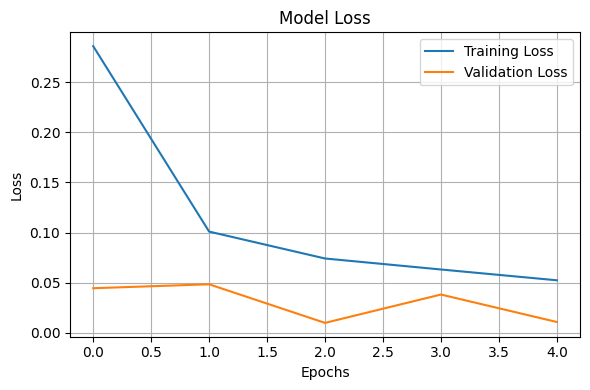

In [24]:
fig_w, fig_h = 6,4
fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Accuracy on the first subplot
axs.plot(tr_acc_all, label='Training Accuracy')
axs.plot(te_acc_all, label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()


fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(tr_loss_all, label='Training Loss')
axs.plot(te_loss_all, label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

## Plotting the training time

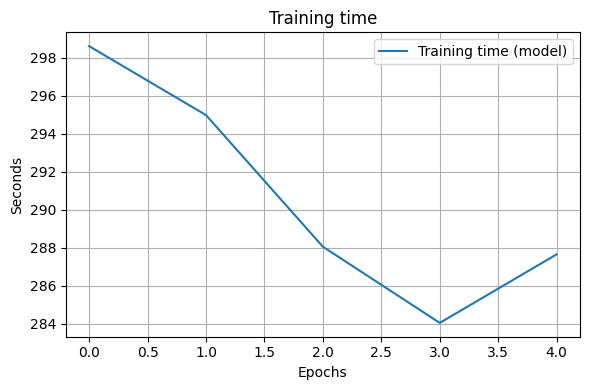

In [25]:
fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(training_time, label='Training time (model)')
axs.set_title('Training time')
axs.set_xlabel('Epochs')
axs.set_ylabel('Seconds')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

# Test Evaluation

In [26]:
agri_class_labels = ["non-agri", "agri"]

In [27]:
%%time
all_preds_pytorch = []
all_labels_pytorch = []
all_probs_pytorch = []

model.eval()
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Step")):
#    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        all_probs_pytorch.extend(probs.cpu())
        all_preds_pytorch.extend(preds.cpu().numpy().flatten())
        all_labels_pytorch.extend(labels.numpy())

Step: 100%|██████████| 38/38 [00:24<00:00,  1.52it/s]

CPU times: user 19.9 s, sys: 1.83 s, total: 21.7 s
Wall time: 25 s


In [36]:
%%time
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve,
                             roc_auc_score,
                             log_loss,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )
from sklearn.preprocessing import label_binarize

# define a function to get the metrics comprehensively
def model_metrics(y_true, y_pred, y_prob, class_labels):
    y_prob = np.array(y_prob)
    if len(y_prob.shape)<2:
        roc_score = roc_auc_score(y_true, y_prob)
    elif len(y_prob.shape)==2:
        roc_score = roc_auc_score(y_true, y_prob[:,1])
    else:
        roc_score = np.nan
    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'Loss': log_loss(y_true, y_prob),
               'F1 Score': f1_score(y_true, y_pred),
               'ROC-AUC': roc_score,
               'Confusion Matrix': confusion_matrix(y_true, y_pred),
               'Classification Report': classification_report(y_true, y_pred, target_names=class_labels, digits=4),
               "Class labels": class_labels
              }
    return metrics

#function to print the metrics
def print_metrics(y_true, y_pred, y_prob, class_labels, model_name):
    metrics = model_metrics(y_true, y_pred, y_prob, class_labels)

    print(f"Evaluation metrics for the \033[1m{model_name}\033[0m")
    print(f"Accuracy: {'':<1}{metrics["Accuracy"]:.4f}")
    if metrics["ROC-AUC"] != np.nan:
        print(f"ROC-AUC: {'':<2}{metrics["ROC-AUC"]:.4f}")
    print(f"Loss: {'':<5}{metrics["Loss"]:.4f}\n")
    print(f"Classification report:\n\n  {metrics["Classification Report"]}")
    print("========= Confusion Matrix =========")
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"],
                                  display_labels=metrics["Class labels"])
    disp.plot()
    plt.show()

CPU times: user 39 µs, sys: 4 µs, total: 43 µs
Wall time: 46 µs


Evaluation metrics for the PyTorch CNN-Vit Hybrid Model
Accuracy:  0.9975
ROC-AUC:   1.0000
Loss:      0.0089

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9983    0.9967    0.9975       599
        agri     0.9967    0.9983    0.9975       601

    accuracy                         0.9975      1200
   macro avg     0.9975    0.9975    0.9975      1200
weighted avg     0.9975    0.9975    0.9975      1200

========= Confusion Matrix =========


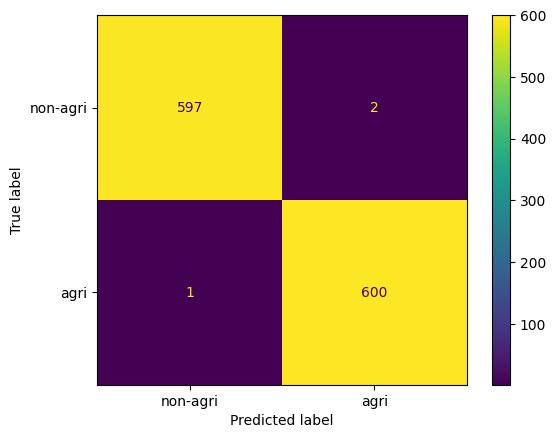

In [37]:
print_metrics(y_true = all_labels_pytorch,
              y_pred = all_preds_pytorch,
              y_prob = np.array(all_probs_pytorch),
              class_labels = agri_class_labels,
              model_name = "PyTorch CNN-Vit Hybrid Model"
             )

In [30]:
def plot_roc(y_true, y_prob, model_name):
    n_classes = y_prob.shape[1] if y_prob.ndim > 1 else 1
    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    else:
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'{model_name} class {i} (AUC = {auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

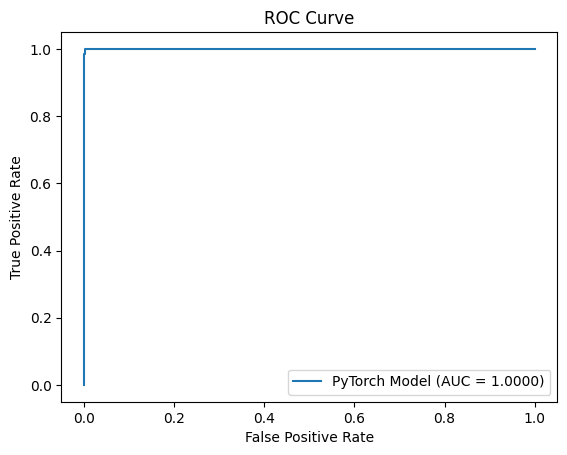

In [31]:
plot_roc(np.array(all_labels_pytorch), np.array(all_probs_pytorch), "PyTorch Model")
plt.show()

In [34]:
# get the PyTorch model performance metrics
metrics_pytorch = model_metrics(all_labels_pytorch, all_preds_pytorch, all_probs_pytorch, agri_class_labels)


# Display the comparison of metrics
print("{:<18} | {:<15}".format('\033[1m'+ 'Metric' + '\033[0m',
                                    'PyTorch Model'))
print(("".join(["-" for _ in range(43)])))
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for k in metrics_list:
    print("{:<18} | {:<15.4f}".format('\033[1m'+k+'\033[0m',
                                              metrics_pytorch[k]))

Metric     | PyTorch Model  
-------------------------------------------
Accuracy   | 0.9975         
Precision  | 0.9967         
Recall     | 0.9983         
F1 Score   | 0.9975         
ROC-AUC    | 1.0000         
